In [7]:
# root to folder with the two trial stks

rtdir = 'C:\\Users\\rasmu\\OneDrive\\Desktop\\TEMP LOCAL FILES\\FXX\\980nm_PreStim60s_pls15_fps6_w05avg\\STKS'

# OBS: frameRate="30.043"
# dwellTime="0.08"
# averageNum="5" 

In [33]:
FR = 30.043/5/1.08

FR

# However if 193fr in 5min/300s

FR2 = 193/300

# 80s in FR2:
bPAC_t = 80*FR2

bPAC_t

51.46666666666667

In [1]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def process_tif_stack(filepath, t1, t2, t3, t4):
    """
    Reads a .tif stack, calculates ratios, and generates heatmaps.

    Args:
        filepath: Path to the .tif stack file.
        t1, t2, t3, t4: Time points defining the ranges for ratio calculation.

    Returns:
        A tuple containing:
            - ratio_heatmap: Heatmap of the calculated ratios.
            - avg_heatmap: Heatmap of the average values of the original stack.
            - original_shape: Shape of the original stack.
    """
    try:
        with tifffile.TiffFile(filepath) as tif:
            image_stack = tif.asarray()
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None, None, None
    except Exception as e:
        print(f"Error reading TIFF file: {e}")
        return None, None, None

    original_shape = image_stack.shape
    z_size, y_size, x_size = original_shape

    # Calculate average stack
    avg_stack = np.mean(image_stack, axis=0)

    num_vectors = y_size * x_size
    data_matrix = np.zeros((num_vectors, z_size), dtype=image_stack.dtype)
    indices = np.zeros((num_vectors, 2), dtype=int)

    vector_index = 0
    for y in range(y_size):
        for x in range(x_size):
            z_vector = image_stack[:, y, x]
            data_matrix[vector_index, :] = z_vector
            indices[vector_index, :] = [x, y]
            vector_index += 1

    ratio_heatmap = np.zeros((y_size, x_size))
    for i in range(num_vectors):
        x, y = indices[i]
        vec = data_matrix[i, :]
        avg_a = np.mean(vec[t1:t2+1])  # +1 because slicing is exclusive of the end
        avg_b = np.mean(vec[t3:t4+1])
        if avg_b != 0: # Avoid division by zero
            ratio = avg_a / avg_b
        else:
            ratio = 0 # Or some other appropriate value/handling for zero division

        ratio_heatmap[y, x] = ratio # Note: y, x order for image indexing

    avg_heatmap = np.mean(image_stack, axis=0)  # Average across the z-axis

    return ratio_heatmap, avg_heatmap, original_shape


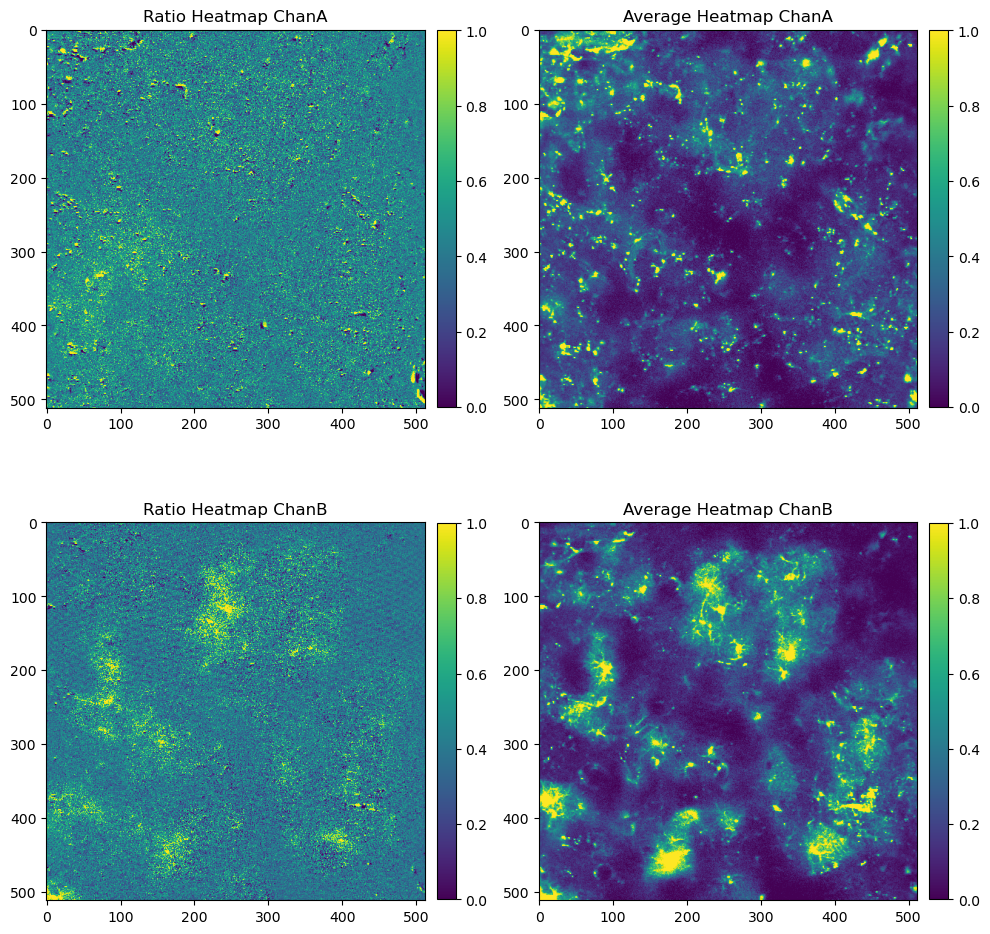

In [41]:
import os
from skimage import exposure 

# Example usage:
filepath_A = os.path.join(rtdir,'ChanA_stk.tif') # Replace with your file path
t1a = 40  # Example values - replace with your desired time points
t2a = 90
t3a = 100
t4a = 150
# Example usage:
filepath_B = os.path.join(rtdir,'ChanB_stk.tif') # Replace with your file path
t1b = 40  # Example values - replace with your desired time points
t2b = 50
t3b = 80
t4b = 90

ratio_heatmap_a, avg_heatmap_a, original_shape_a = process_tif_stack(filepath_A, t1a, t2a, t3a, t4a)
ratio_heatmap_b, avg_heatmap_b, original_shape_b = process_tif_stack(filepath_B, t1b, t2b, t3b, t4b)

if ratio_heatmap is not None:
    # Display the heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Contrast Stretching (using skimage.exposure)
    p2, p98 = np.percentile(ratio_heatmap_a, (2, 98)) # Calculate percentiles for stretching
    ratio_heatmap_a_stretched = exposure.rescale_intensity(ratio_heatmap_a, in_range=(p2, p98)) # Stretch

    p2, p98 = np.percentile(avg_heatmap_a, (2, 98)) # Calculate percentiles for stretching
    avg_heatmap_a_stretched = exposure.rescale_intensity(avg_heatmap_a, in_range=(p2, p98)) # Stretch

    p2, p98 = np.percentile(ratio_heatmap_b, (2, 98)) # Calculate percentiles for stretching
    ratio_heatmap_b_stretched = exposure.rescale_intensity(ratio_heatmap_b, in_range=(p2, p98)) # Stretch

    p2, p98 = np.percentile(avg_heatmap_b, (2, 98)) # Calculate percentiles for stretching
    avg_heatmap_b_stretched = exposure.rescale_intensity(avg_heatmap_b, in_range=(p2, p98)) # Stretch


    im1 = axes[0, 0].imshow(ratio_heatmap_a_stretched, cmap='viridis')  # Use stretched data
    axes[0, 0].set_title("Ratio Heatmap ChanA")
    fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.03)

    im2 = axes[0, 1].imshow(avg_heatmap_a_stretched, cmap='viridis')  # Use stretched data
    axes[0, 1].set_title("Average Heatmap ChanA")
    fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.03)

    im3 = axes[1, 0].imshow(ratio_heatmap_b_stretched, cmap='viridis')  # Use stretched data
    axes[1, 0].set_title("Ratio Heatmap ChanB")
    fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.03)

    im4 = axes[1, 1].imshow(avg_heatmap_b_stretched, cmap='viridis')  # Use stretched data
    axes[1, 1].set_title("Average Heatmap ChanB")
    fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.03)

    plt.tight_layout()
    plt.show()
else:
    print("Failed to process the TIFF stack.")

Text(0, 0.5, 'Frequency')

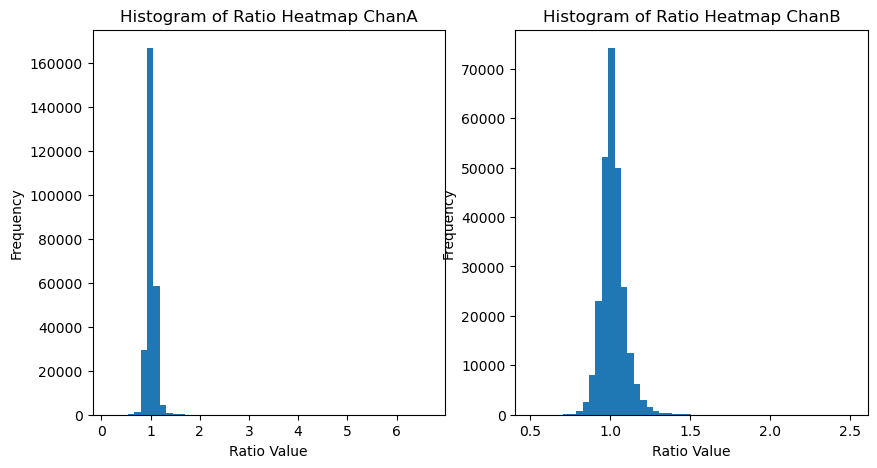

In [45]:
# --- Histogram Plots ---
fig_histograms, axes_histograms = plt.subplots(1, 2, figsize=(10, 5))  # Separate figure for histograms

axes_histograms[0].hist(ratio_heatmap_a.ravel(), bins=50)
axes_histograms[0].set_title("Histogram of Ratio Heatmap ChanA")
axes_histograms[0].set_xlabel("Ratio Value")
axes_histograms[0].set_ylabel("Frequency")

axes_histograms[1].hist(ratio_heatmap_b.ravel(), bins=50)
axes_histograms[1].set_title("Histogram of Ratio Heatmap ChanB")
axes_histograms[1].set_xlabel("Ratio Value")
axes_histograms[1].set_ylabel("Frequency")